In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import zipfile
import os

# 1. Unzip the dataset
zip_path = "/content/drive/MyDrive/Dataset/Cotton_Disease_Dataset_Balanced.zip"
extract_path = "/content/Cotton_Disease_Dataset_Balanced"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Dataset extracted!")

# 2. Browse the folder structure
for root, dirs, files in os.walk(extract_path):
    level = root.replace(extract_path, '').count(os.sep)
    indent = ' ' * 4 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 4 * (level + 1)
    for f in files[:5]:  # show only first 5 files per folder
        print(f"{subindent}{f}")

# 3. Count images per class
from collections import defaultdict

image_counts = defaultdict(int)

for root, dirs, files in os.walk(extract_path):
    class_name = os.path.basename(root)
    image_counts[class_name] += len([f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

print("\n📊 Images per class:")
for cls, count in image_counts.items():
    print(f"{cls}: {count}")


✅ Dataset extracted!
Cotton_Disease_Dataset_Balanced/
    Healthy Leaf/
        aug_0_2625.jpg
        aug_0_7035.jpg
        HL00099.jpg
        aug_0_2765.jpg
        HL00149.jpg
    Curl Virus/
        aug_0_1082.jpg
        CV00371.jpg
        CV00191.jpg
        aug_0_8378.jpg
        CV00032.jpg
    Powdery mildew/
        rotate_zoompil_brightness_25.jpg
        random_crop_pil_brightness_19.jpg
        rotate_zoompil_sharpness_22.jpg
        aug_0_6955.jpg
        vertical_flippil_brightness_23.jpg
    Bacterial Blight/
        BBC00103.jpg
        aug_0_8798.jpg
        aug_0_2232.jpg
        aug_0_2958.jpg
        aug_0_852.jpg
    Target spot/
        aug_0_1914.jpg
        rotate_zoompil_brightness_25.jpg
        random_crop_pil_brightness_19.jpg
        rotate_zoompil_sharpness_22.jpg
        vertical_flippil_brightness_23.jpg

📊 Images per class:
Cotton_Disease_Dataset_Balanced: 0
Healthy Leaf: 974
Curl Virus: 991
Powdery mildew: 998
Bacterial Blight: 977
Target spot: 997

Found 3952 images belonging to 5 classes.
Found 985 images belonging to 5 classes.
Class Weights: {0: np.float64(1.0107416879795397), 1: np.float64(0.9967213114754099), 2: np.float64(1.0133333333333334), 3: np.float64(0.9892365456821026), 4: np.float64(0.9904761904761905)}


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 0.2602 - loss: 1.6001 - val_accuracy: 0.3787 - val_loss: 1.4862 - learning_rate: 5.0000e-04
Epoch 2/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 84s 680ms/step - accuracy: 0.3289 - loss: 1.4905 - val_accuracy: 0.3817 - val_loss: 1.3753 - learning_rate: 5.0000e-04
Epoch 3/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 85s 689ms/step - accuracy: 0.3592 - loss: 1.4040 - val_accuracy: 0.4183 - val_loss: 1.3203 - learning_rate: 5.0000e-04
Epoch 4/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 85s 680ms/step - accuracy: 0.3719 - loss: 1.3765 - val_accuracy: 0.4518 - val_loss: 1.2977 - learning_rate: 5.0000e-04
Epoch 5/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 88s 712ms/step - accuracy: 0.3635 - loss: 1.3639 - val_accuracy: 0.4132 - val_loss: 1.2741 - learning_rate: 5.0000e-04
Epoch 6/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 139s 686ms/step - accuracy: 0.3655 - loss: 1.3311 - val_accuracy: 0.4569 - val_loss: 1.2601 - learning_rate: 5.0000e-04
Epoch 7/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 86s 691

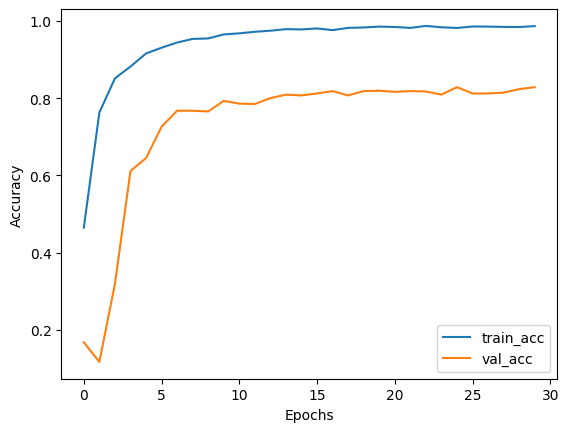

31/31 ━━━━━━━━━━━━━━━━━━━━ 36s 851ms/step


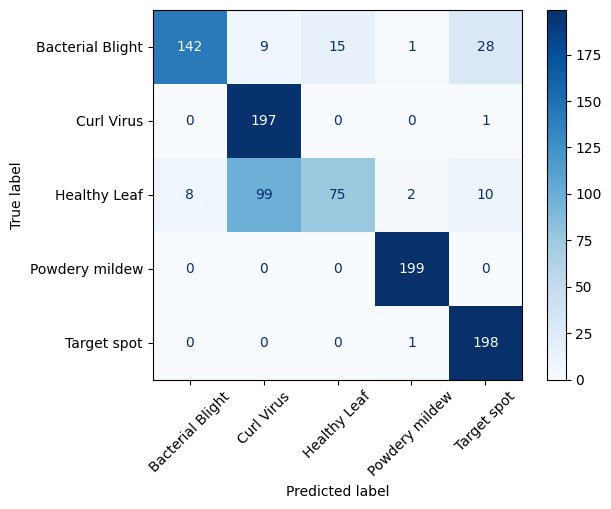

Classification Report:

                  precision    recall  f1-score   support

Bacterial Blight       0.95      0.73      0.82       195
      Curl Virus       0.65      0.99      0.78       198
    Healthy Leaf       0.83      0.39      0.53       194
  Powdery mildew       0.98      1.00      0.99       199
     Target spot       0.84      0.99      0.91       199

        accuracy                           0.82       985
       macro avg       0.85      0.82      0.81       985
    weighted avg       0.85      0.82      0.81       985



In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# ==============================
# Dataset Paths
# ==============================
train_dir = "Cotton_Disease_Dataset_Balanced"

# ==============================
# Data Generators with Augmentation
# ==============================
datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.2,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    channel_shift_range=30
)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # EfficientNetB3 input size
    batch_size=32,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    subset="validation",
    shuffle=False   # important for confusion matrix
)

# ==============================
# Compute Class Weights
# ==============================
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

# ==============================
# Build EfficientNetB3 Model
# ==============================
base_model = EfficientNetB3(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # freeze base model initially

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(train_generator.num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0005), loss="categorical_crossentropy", metrics=["accuracy"])

# ==============================
# Callbacks
# ==============================
lr_reduction = ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=3, verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True)

# ==============================
# Step 1: Train Top Layers
# ==============================
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    callbacks=[lr_reduction, early_stop],
    class_weight=class_weights,
    verbose=1
)

# ==============================
# Step 2: Fine-tune Entire Model
# ==============================
base_model.trainable = True
model.compile(optimizer=Adam(learning_rate=1e-5), loss="categorical_crossentropy", metrics=["accuracy"])

history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[lr_reduction, early_stop],
    class_weight=class_weights,
    verbose=1
)

# ==============================
# Save Model
# ==============================
model.save("updated_cotton_disease_efficientnetb3.h5")

# ==============================
# Plot Training Curves
# ==============================
plt.plot(history_fine.history["accuracy"], label="train_acc")
plt.plot(history_fine.history["val_accuracy"], label="val_acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# ==============================
# Evaluate & Confusion Matrix
# ==============================
# Predict on validation set
Y_pred = model.predict(val_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Confusion matrix
cm = confusion_matrix(val_generator.classes, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=val_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.show()

# Classification report
print("Classification Report:\n")
print(classification_report(val_generator.classes, y_pred, target_names=val_generator.class_indices.keys()))

# ==============================
# Test Single Image Prediction
# ==============================
def predict_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    preds = model.predict(img_array)
    class_labels = list(train_generator.class_indices.keys())
    predicted_class = class_labels[np.argmax(preds)]
    confidence = np.max(preds) * 100

    print(f"Prediction: {predicted_class} ({confidence:.2f}%)")
    return predicted_class, confidence

# Example usage:
# predict_image("Cotton_Disease_Dataset_Balanced/Target spot/rotate_zoompil_sharpness_28.jpg")



31/31 ━━━━━━━━━━━━━━━━━━━━ 17s 541ms/step


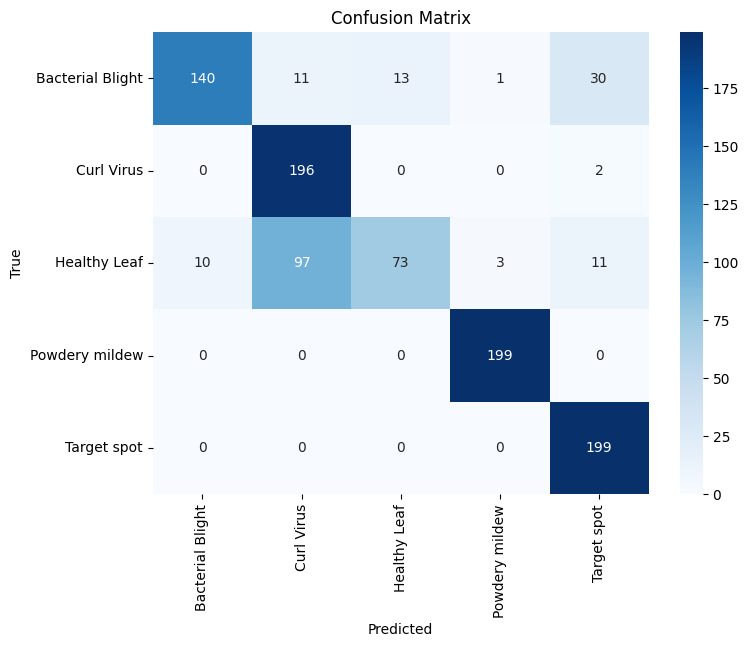

Classification Report:
                  precision    recall  f1-score   support

Bacterial Blight       0.93      0.72      0.81       195
      Curl Virus       0.64      0.99      0.78       198
    Healthy Leaf       0.85      0.38      0.52       194
  Powdery mildew       0.98      1.00      0.99       199
     Target spot       0.82      1.00      0.90       199

        accuracy                           0.82       985
       macro avg       0.85      0.82      0.80       985
    weighted avg       0.85      0.82      0.80       985



In [8]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# ==============================
# Evaluate Model with Confusion Matrix & Report
# ==============================

# Get ground truth labels and predictions
val_generator.reset()
Y_pred = model.predict(val_generator, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)
y_true = val_generator.classes

# Class labels
class_labels = list(val_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))


In [9]:
# ==============================
# Evaluate Model on Validation Set
# ==============================
val_loss, val_acc = model.evaluate(val_generator, verbose=1)

print("✅ Final Validation Accuracy: {:.2f}%".format(val_acc * 100))
print("✅ Final Validation Loss: {:.4f}".format(val_loss))


31/31 ━━━━━━━━━━━━━━━━━━━━ 22s 656ms/step - accuracy: 0.7333 - loss: 0.7679
✅ Final Validation Accuracy: 81.73%
✅ Final Validation Loss: 0.5007


In [10]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# ==============================
# Load the saved model
# ==============================
model = load_model("/content/updated_cotton_disease_efficientnetb3.h5")

# ==============================
# Test on a single image
# ==============================
img_path = "/content/Cotton_Disease_Dataset_Balanced/Powdery mildew/10.jpg"   # change to your image path
img_size = 224   # same size used during training

# Load and preprocess image
img = image.load_img(img_path, target_size=(img_size, img_size))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)  # add batch dimension

# Predict
pred = model.predict(img_array)
class_index = np.argmax(pred[0])   # get index of highest probability
confidence = np.max(pred[0]) * 100

# Map class index to label
class_labels = list(train_generator.class_indices.keys())  # same labels from training
predicted_class = class_labels[class_index]

print(f"✅ Predicted Class: {predicted_class}")
print(f"✅ Confidence: {confidence:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step
✅ Predicted Class: Powdery mildew
✅ Confidence: 99.98%
